Num GPUs Available: 1
TensorFlow version: 2.17.1
Eager execution: True
Label Mapping (index → class):
 0 → Ball out of play
 1 → Clearance
 2 → Corner
 3 → Direct free-kick
 4 → Foul
 5 → Goal
 6 → Indirect free-kick
 7 → Kick-off
 8 → Offside
 9 → Penalty
10 → Red card
11 → Shots off target
12 → Shots on target
13 → Substitution
14 → Throw-in
15 → Yellow card
16 → Yellow-_red card
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step

Predicted event class: Offside
Prediction confidence: 0.4238


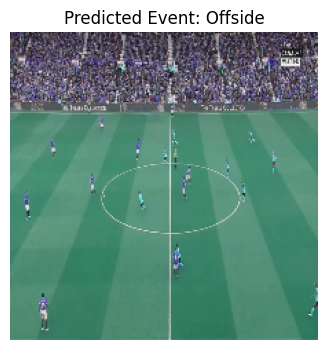

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())

# Custom MoViNet Feature Extractor using TensorFlow Hub
class MoViNetFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, hub_url, **kwargs):
        super().__init__(**kwargs)
        self.hub_url = hub_url
        self.feature_extractor = hub.KerasLayer(hub_url, trainable=False)

    def call(self, inputs):
        return self.feature_extractor({"image": inputs})

    def get_config(self):
        config = super().get_config()
        config.update({'hub_url': self.hub_url})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Define Model Architecture
def create_model(model_url):
    inputs = tf.keras.Input(shape=(30, 224, 224, 3), name='input_video')
    x = MoViNetFeatureExtractor(model_url, trainable=False)(inputs)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(17, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# Load the full model with pre-defined weights
def load_model_from_keras(model_path, model_url):
    model = create_model(model_url)
    model.load_weights(model_path)
    return model

# Load and preprocess video frames
def load_video(video_path, max_frames=30, target_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []

    for _ in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = frame / 255.0  # Normalize to [0,1]
        frames.append(frame)

    cap.release()

    while len(frames) < max_frames:
        frames.append(np.zeros(target_size + (3,), dtype=np.float32))

    return np.array(frames, dtype=np.float32)

# Run prediction and visualize result
def test_model_on_video(model, video_path, class_names, max_frames=30):
    video_data = load_video(video_path, max_frames)
    video_data = np.expand_dims(video_data, axis=0)

    predictions = model.predict(video_data)
    predicted_class_idx = np.argmax(predictions, axis=-1)[0]

    print(f"\nPredicted event class: {class_names[predicted_class_idx]}")
    print("Prediction confidence:", np.max(predictions))

    # Visualize the first frame
    plt.figure(figsize=(6, 4))
    plt.imshow(video_data[0][0])
    plt.title(f"Predicted Event: {class_names[predicted_class_idx]}")
    plt.axis("off")
    plt.show()

# Read class labels from training set
def get_class_names(data_dir):
    class_names = sorted([
        folder for folder in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, folder))
    ])
    print("Label Mapping (index → class):")
    for idx, name in enumerate(class_names):
        print(f"{idx:2d} → {name}")
    return class_names

# Main
if __name__ == "__main__":
    # TensorFlow Hub model link
    model_id = 'a3'
    mode = 'base'
    version = '3'
    model_url = f"https://tfhub.dev/tensorflow/movinet/{model_id}/{mode}/kinetics-600/classification/{version}"

    # Path to .keras model file uploaded in Kaggle dataset
    model_path = "/kaggle/input/movinet_model200/keras/default/1/movinet_final_model.keras"

    # Load model
    model = load_model_from_keras(model_path, model_url)

    # Class names from training directory
    class_names = get_class_names("/kaggle/input/capstone-dataset/split_data/train")

    # Provide your video path (.mkv works too!)
    video_path = "/kaggle/input/testing-dataset/1_720p.mkv"
    test_model_on_video(model, video_path, class_names)
